# Blackjack-v1

In [1]:
%matplotlib inline

import sys
import logging
import itertools

import numpy as np
np.random.seed(0)
import gym
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

### Use Environment

In [2]:
env = gym.make('Blackjack-v1')
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

00:01:34 [INFO] env: <StepAPICompatibility<PassiveEnvChecker<BlackjackEnv<Blackjack-v1>>>>
00:01:34 [INFO] _action_space: None
00:01:34 [INFO] _observation_space: None
00:01:34 [INFO] _reward_range: None
00:01:34 [INFO] _metadata: None
00:01:34 [INFO] new_step_api: True
00:01:34 [INFO] _has_reset: False
00:01:34 [INFO] _disable_render_order_enforcing: False
00:01:34 [INFO] id: Blackjack-v1
00:01:34 [INFO] entry_point: gym.envs.toy_text.blackjack:BlackjackEnv
00:01:34 [INFO] reward_threshold: None
00:01:34 [INFO] nondeterministic: False
00:01:34 [INFO] max_episode_steps: None
00:01:34 [INFO] order_enforce: True
00:01:34 [INFO] autoreset: False
00:01:34 [INFO] disable_env_checker: False
00:01:34 [INFO] new_step_api: False
00:01:34 [INFO] kwargs: {'sab': True, 'natural': False}
00:01:34 [INFO] namespace: None
00:01:34 [INFO] name: Blackjack
00:01:34 [INFO] version: 1


In [3]:
def ob2state(observation):
    return observation[0], observation[1], int(observation[2])

def play_policy(env, policy=None, verbose=False):
    observation, _ = env.reset()
    reward, terminated, truncated = 0., False, False
    episode_reward, elapsed_steps = 0., 0
    if verbose:
        logging.info('observation = %s', observation)
    while True:
        if verbose:
            logging.info('player = %s, dealer = %s', env.player, env.dealer)
        if policy is None:
            action = env.action_space.sample()
        else:
            state = ob2state(observation)
            action = np.random.choice(env.action_space.n, p=policy[state])
        if verbose:
            logging.info('action = %s', action)
        observation, reward, terminated, truncated, _ = env.step(action)
        if verbose:
            logging.info('observation = %s', observation)
            logging.info('reward = %s', reward)
            logging.info('terminated = %s', terminated)
            logging.info('truncated = %s', truncated)
        episode_reward += reward
        elapsed_steps += 1
        if terminated or truncated:
            break
    return episode_reward, elapsed_steps

episode_reward, elapsed_steps = play_policy(env, verbose=True)
logging.info("episode reward: %.2f", episode_reward)

00:01:34 [INFO] observation = (20, 5, False)
00:01:34 [INFO] player = [10, 10], dealer = [5, 10]
00:01:34 [INFO] action = 0
00:01:34 [INFO] observation = (20, 5, False)
00:01:34 [INFO] reward = 1.0
00:01:34 [INFO] terminated = True
00:01:34 [INFO] truncated = False
00:01:34 [INFO] episode reward: 1.00


### On-policy Monte Carlo

Monte Carlo prediction

In [4]:
def evaluate_action_monte_carlo(env, policy, episode_num=500000):
    q = np.zeros_like(policy)  # action value
    c = np.zeros_like(policy)  # count
    for _ in range(episode_num):
        # play an episode
        state_actions = []
        observation, _ = env.reset()
        while True:
            state = ob2state(observation)
            action = np.random.choice(env.action_space.n, p=policy[state])
            state_actions.append((state, action))
            observation, reward, terminated, truncated, _ = env.step(action)
            if terminated or truncated:
                break  # end of episode
        g = reward  # return
        for state, action in state_actions:
            c[state][action] += 1.
            q[state][action] += (g - q[state][action]) / c[state][action]
    return q

In [5]:
policy = np.zeros((22, 11, 2, 2))
policy[20:, :, :, 0] = 1  # stand when >=20
policy[:20, :, :, 1] = 1  # hit when <20

q = evaluate_action_monte_carlo(env, policy)  # action value
v = (q * policy).sum(axis=-1)  # state value

In [6]:
def plot(data):
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))
    titles = ['without ace', 'with ace']
    have_aces = [0, 1]
    extent = [12, 22, 1, 11]
    for title, have_ace, axis in zip(titles, have_aces, axes):
        dat = data[extent[0]:extent[1], extent[2]:extent[3], have_ace].T
        axis.imshow(dat, extent=extent, origin='lower')
        axis.set_xlabel('player sum')
        axis.set_ylabel('dealer showing')
        axis.set_title(title)

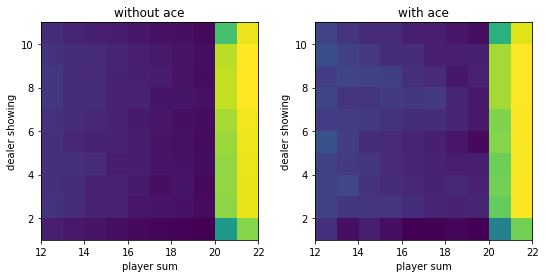

In [7]:
plot(v)

Test Policy

In [8]:
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_policy(env, policy)
    episode_rewards.append(episode_reward)
    logging.info('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

00:05:08 [INFO] test episode 0: reward = 1.00, steps = 1
00:05:08 [INFO] test episode 1: reward = -1.00, steps = 3
00:05:08 [INFO] test episode 2: reward = 1.00, steps = 4
00:05:08 [INFO] test episode 3: reward = 1.00, steps = 1
00:05:08 [INFO] test episode 4: reward = -1.00, steps = 1
00:05:08 [INFO] test episode 5: reward = -1.00, steps = 2
00:05:08 [INFO] test episode 6: reward = -1.00, steps = 2
00:05:08 [INFO] test episode 7: reward = -1.00, steps = 1
00:05:08 [INFO] test episode 8: reward = 1.00, steps = 2
00:05:08 [INFO] test episode 9: reward = 1.00, steps = 3
00:05:08 [INFO] test episode 10: reward = -1.00, steps = 2
00:05:08 [INFO] test episode 11: reward = 1.00, steps = 2
00:05:08 [INFO] test episode 12: reward = -1.00, steps = 2
00:05:08 [INFO] test episode 13: reward = -1.00, steps = 1
00:05:08 [INFO] test episode 14: reward = -1.00, steps = 2
00:05:08 [INFO] test episode 15: reward = 1.00, steps = 2
00:05:08 [INFO] test episode 16: reward = -1.00, steps = 1
00:05:08 [INFO

In [9]:
observation, _ = env.reset()
logging.info("observation = %s", observation)
state = ob2state(observation)
logging.info("state = %s", state)
probs = policy[state]
logging.info("probs = %s", probs)

00:05:08 [INFO] observation = (12, 5, False)
00:05:08 [INFO] state = (12, 5, 0)
00:05:08 [INFO] probs = [0. 1.]


#### Monte Carlo update with exploring start

In [10]:
def monte_carlo_with_exploring_start(env, episode_num=500000):
    policy = np.zeros((22, 11, 2, 2))
    policy[:, :, :, 1] = 1.
    q = np.zeros_like(policy)  # action values
    c = np.zeros_like(policy)  # counts
    for _ in range(episode_num):
        # choose initial state randomly
        state = (np.random.randint(12, 22),
                 np.random.randint(1, 11),
                 np.random.randint(2))
        action = np.random.randint(2)
        # play an episode
        env.reset()
        if state[2]:  # has ace
            env.unwrapped.player = [1, state[0] - 11]
        else:  # no ace
            if state[0] == 21:
                env.unwrapped.player = [10, 9, 2]
            else:
                env.unwrapped.player = [10, state[0] - 10]
        env.unwrapped.dealer[0] = state[1]
        state_actions = []
        while True:
            state_actions.append((state, action))
            observation, reward, terminated, truncated, _ = env.step(action)
            if terminated or truncated:
                break  # end of episode
            state = ob2state(observation)
            action = np.random.choice(env.action_space.n, p=policy[state])
        g = reward  # return
        for state, action in state_actions:
            c[state][action] += 1.
            q[state][action] += (g - q[state][action]) / c[state][action]
            a = q[state].argmax()
            policy[state] = 0.
            policy[state][a] = 1.
    return policy, q

In [11]:
policy, q = monte_carlo_with_exploring_start(env)
v = q.max(axis=-1)

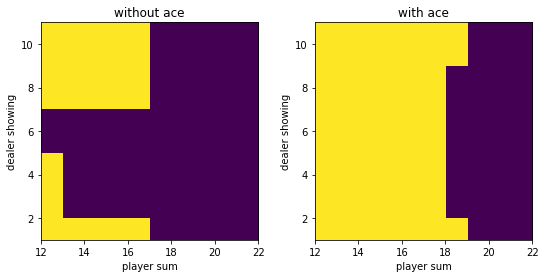

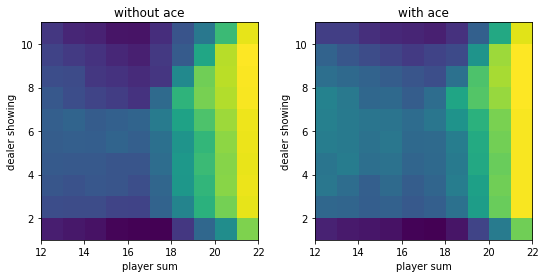

In [12]:
plot(policy.argmax(-1))
plot(v)

Monte Carlo update with soft poicy

In [13]:
def monte_carlo_with_soft(env, episode_num=500000, epsilon=0.1):
    policy = np.ones((22, 11, 2, 2)) * 0.5  # soft policy
    q = np.zeros_like(policy)  # action values
    c = np.zeros_like(policy)  # counts
    for _ in range(episode_num):
        # play an episode
        state_actions = []
        observation, _ = env.reset()
        while True:
            state = ob2state(observation)
            action = np.random.choice(env.action_space.n, p=policy[state])
            state_actions.append((state, action))
            observation, reward, terminated, truncated, _ = env.step(action)
            if terminated or truncated:
                break  # end of episode
        g = reward  # return
        for state, action in state_actions:
            c[state][action] += 1.
            q[state][action] += (g - q[state][action]) / c[state][action]
            # soft update
            a = q[state].argmax()
            policy[state] = epsilon / 2.
            policy[state][a] += (1. - epsilon)
    return policy, q

In [14]:
policy, q = monte_carlo_with_soft(env)
v = q.max(axis=-1)

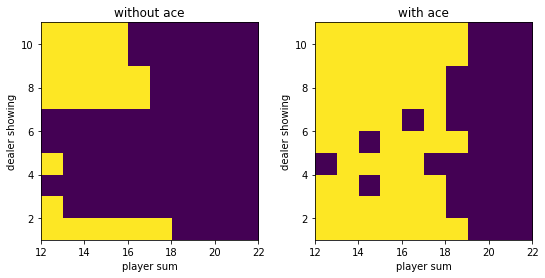

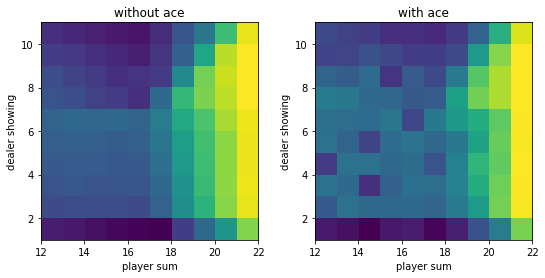

In [15]:
plot(policy.argmax(-1))
plot(v)

Test Policy

In [16]:
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_policy(env, policy)
    episode_rewards.append(episode_reward)
    logging.info('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

00:11:20 [INFO] test episode 0: reward = -1.00, steps = 1
00:11:20 [INFO] test episode 1: reward = -1.00, steps = 2
00:11:20 [INFO] test episode 2: reward = -1.00, steps = 1
00:11:20 [INFO] test episode 3: reward = -1.00, steps = 1
00:11:20 [INFO] test episode 4: reward = 1.00, steps = 2
00:11:20 [INFO] test episode 5: reward = 0.00, steps = 2
00:11:20 [INFO] test episode 6: reward = 1.00, steps = 2
00:11:20 [INFO] test episode 7: reward = -1.00, steps = 1
00:11:20 [INFO] test episode 8: reward = 0.00, steps = 1
00:11:20 [INFO] test episode 9: reward = -1.00, steps = 1
00:11:20 [INFO] test episode 10: reward = -1.00, steps = 2
00:11:20 [INFO] test episode 11: reward = -1.00, steps = 3
00:11:20 [INFO] test episode 12: reward = 1.00, steps = 1
00:11:20 [INFO] test episode 13: reward = -1.00, steps = 1
00:11:20 [INFO] test episode 14: reward = 1.00, steps = 1
00:11:20 [INFO] test episode 15: reward = 1.00, steps = 2
00:11:20 [INFO] test episode 16: reward = -1.00, steps = 1
00:11:20 [INFO

### Off-Policy Monte Carlo Update

Monte Carlo evaluation with importance sampling

In [17]:
def evaluate_monte_carlo_importance_sample(env, policy, behavior_policy,
        episode_num=500000):
    q = np.zeros_like(policy)  # action values
    c = np.zeros_like(policy)  # counts
    for _ in range(episode_num):
        # play episode using behavior policy
        state_actions = []
        observation, _ = env.reset()
        while True:
            state = ob2state(observation)
            action = np.random.choice(env.action_space.n,
                    p=behavior_policy[state])
            state_actions.append((state, action))
            observation, reward, terminated, truncated, _ = env.step(action)
            if terminated or truncated:
                break  # finish the episode
        g = reward  # return
        rho = 1.  # importance sampling ratio
        for state, action in reversed(state_actions):
            c[state][action] += rho
            q[state][action] += (rho / c[state][action] * (g - q[state][action]))
            rho *= (policy[state][action] / behavior_policy[state][action])
            if rho == 0:
                break  # early stop
    return q

In [18]:
policy = np.zeros((22, 11, 2, 2))
policy[20:, :, :, 0] = 1  # stand when >=20
policy[:20, :, :, 1] = 1  # hit when <20
behavior_policy = np.ones_like(policy) * 0.5
q = evaluate_monte_carlo_importance_sample(env, policy, behavior_policy)
v = (q * policy).sum(axis=-1)

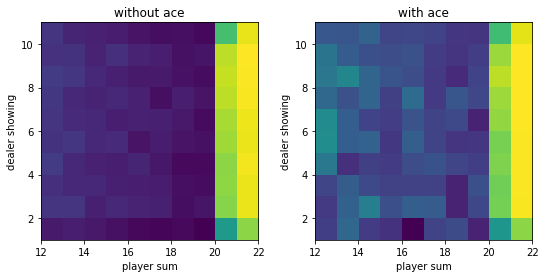

In [19]:
plot(v)

Monte Carlo update with importance sampling

In [20]:
def monte_carlo_importance_sample(env, episode_num=500000):
    policy = np.zeros((22, 11, 2, 2))
    policy[:, :, :, 0] = 1.
    behavior_policy = np.ones_like(policy) * 0.5  # soft policy
    q = np.zeros_like(policy)  # action values
    c = np.zeros_like(policy)  # counts
    for _ in range(episode_num):
        # play using behavior policy
        state_actions = []
        observation, _ = env.reset()
        while True:
            state = ob2state(observation)
            action = np.random.choice(env.action_space.n,
                    p=behavior_policy[state])
            state_actions.append((state, action))
            observation, reward, terminated, truncated, _ = env.step(action)
            if terminated or truncated:
                break  # finish the episode
        g = reward  # return
        rho = 1.  # importance sampling ratio
        for state, action in reversed(state_actions):
            c[state][action] += rho
            q[state][action] += (rho / c[state][action] * (g - q[state][action]))
            # improve the policy
            a = q[state].argmax()
            policy[state] = 0.
            policy[state][a] = 1.
            if a != action:  # early stop
                break
            rho /= behavior_policy[state][action]
    return policy, q

In [21]:
policy, q = monte_carlo_importance_sample(env)
v = q.max(axis=-1)

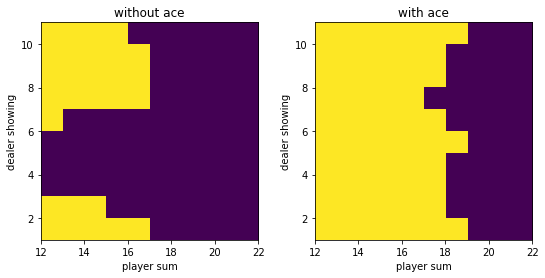

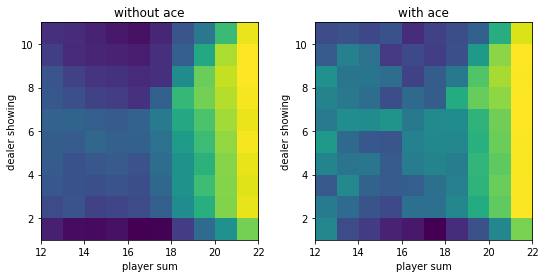

In [22]:
plot(policy.argmax(-1))
plot(v)

Test Policy

In [23]:
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_policy(env, policy)
    episode_rewards.append(episode_reward)
    logging.info('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

00:17:35 [INFO] test episode 0: reward = 1.00, steps = 3
00:17:35 [INFO] test episode 1: reward = 0.00, steps = 1
00:17:35 [INFO] test episode 2: reward = -1.00, steps = 3
00:17:35 [INFO] test episode 3: reward = 1.00, steps = 1
00:17:35 [INFO] test episode 4: reward = 1.00, steps = 2
00:17:35 [INFO] test episode 5: reward = -1.00, steps = 3
00:17:35 [INFO] test episode 6: reward = -1.00, steps = 2
00:17:35 [INFO] test episode 7: reward = -1.00, steps = 1
00:17:35 [INFO] test episode 8: reward = 1.00, steps = 1
00:17:35 [INFO] test episode 9: reward = -1.00, steps = 1
00:17:35 [INFO] test episode 10: reward = 1.00, steps = 1
00:17:35 [INFO] test episode 11: reward = -1.00, steps = 1
00:17:35 [INFO] test episode 12: reward = 1.00, steps = 2
00:17:35 [INFO] test episode 13: reward = 1.00, steps = 1
00:17:35 [INFO] test episode 14: reward = 1.00, steps = 2
00:17:35 [INFO] test episode 15: reward = -1.00, steps = 3
00:17:35 [INFO] test episode 16: reward = 1.00, steps = 1
00:17:35 [INFO] t

In [24]:
env.close()